# The Basic Solow Model and an extension with Technological Growth

**Table of contents**
- 1. [The Basic Solow Model](#toc1_)
  - 1.1. [Analytical Solution](#toc1_1_)
  - 1.2. [Numerical Solution](#toc1_2_)
  - 1.3. [Interactive Plot](#toc1_3_)
- 2. [The Solow Model with Technological Growth](#toc2_)
  - 2.1. [Analytical Solution](#toc2_1_)
  - 2.2. [Numerical Solution](#toc2_2_)
  - 2.3. [Interactive Plot](#toc2_3_)
- 3. [Shock to the Saving Rate](#toc3_)
- 4. [Shock to Technological Growth](#toc4_)
- 5. [Conclusion](#toc5_)


<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In this project we will analyse The Basic Solow Model and make an extension with technological growth. We include technological growth because there is no growth in the long run in The Basic Solow Model. This is due to the diminishing marginal product w.r.t. capital.  Technological growth will make the Solow Model closer to reality. In the end we will consider a permanent shock to both the saving rate and technological growth in the extended Solow Model. 

We import and set magics:

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import sympy as sm
from ipywidgets import interact, widgets

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

from modelproject import SolowModelTech
from modelproject import SolowModel
from modelproject import Shocks

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1 <a id='toc1_'></a>[The Basic Solow Model](#toc0_)


The Basic Solow Model is an exogenous model for a closed economy. The production is determined by two factors in the supply side: physical capital, K, and labor, L. Physical capital is things like machines, factories, buildings and so on, where the labor is the population in the society. Capital and labor accumulate over time. The production can either be consumed today or invested in machines which will increase the production tomorrow. 

**The equations for The Basic Solow Model**
$$Y_t=BK^\alpha_tL^{1-\alpha}_t, \quad 0<\alpha<1 \tag{1}$$
$$K_{t+1}=(1-\delta)K_t+S_t, \quad 0<\delta<1 \tag{2}$$
$$S_t=sY_t, \quad 0<s<1 \tag{3}$$
$$L_{t+1}=(1+n)L_t \tag{4}$$
$$r_t=\alpha B\left(\frac{K_t}{L_t}\right)^{\alpha-1} \tag{5}$$
$$w_t=(1-\alpha)B\left(\frac{K_t}{L_t}\right)^\alpha \tag{6}$$


Where $y_t\equiv\frac{Y_t}{L_t}$ and $k_t\equiv\frac{K_t}{L_t}$.


### 1.1 <a id='toc1_1_'></a>[Analytical solution](#toc0_)

We start by using sympy to find an analytical expression for steady state in The Basic Solow Model. This means that we will solve:
$$k^*=\frac{1}{1+n}(sBk^{*\alpha}+(1-{\delta})k^*)$$
$$y^*=B(k^*)^\alpha$$

In [45]:
#Define symbols
kstar = sm.symbols('k^*')
ystar = sm.symbols('y^*')
n = sm.symbols('n')
s = sm.symbols('s')
B = sm.symbols('B')
alpha = sm.symbols('alpha')
delta = sm.symbols('delta')

In [46]:
#Find steady state for k
ssk = sm.Eq(kstar,((s*B*kstar**alpha+(1-delta)*kstar)/(1+n)))
ss_k = sm.solve(ssk,kstar)[0]
s_s_k = sm.Eq(kstar,ss_k)

#Find steady state for y
ssy = sm.Eq(ystar,((B*ss_k**alpha)))
ss_y = sm.solve(ssy,ystar)[0]
s_s_y = sm.Eq(ystar,ss_y)

#Show the results
display(s_s_k)
display(s_s_y)

Eq(k^*, (B*s/(delta + n))**(-1/(alpha - 1)))

Eq(y^*, B*((B*s/(delta + n))**(-1/(alpha - 1)))**alpha)

In [47]:
#We will now turn our solution into a Python function
ssk_func = sm.lambdify((B, s, delta, n, alpha), ss_k)

ssy_func = sm.lambdify((B, s, delta, n, alpha), ss_y)

#We will now evaluate the functions with specific parameters:
ssk_value = ssk_func(1, 0.2, 0.05, 0.02, 1/3)

ssy_value = ssy_func(1, 0.2, 0.05, 0.02, 1/3)

# Print the values
print('Steady state value of capital: {:.3f}'.format(ssk_value))
print('Steady state value of output: {:.3f}'.format(ssy_value))

Steady state value of capital: 4.829
Steady state value of output: 1.690


### 1.2 <a id='toc1_2_'></a>[Numerical solution](#toc0_)

We will now find steady state by the numerical solution of The Basic Solow Model. 
To do this, we start by defining the parameters. Then we find steady state for k and y using the root finding optimizer, optimize.root_scalar, where we use two different methods Brentq and Bisect. We will try both of them to see which is the best.
The brentq method is a root-finding algorithm based on Brent's method, which is also known as the Brent-Dekker method. This algorithm is used to find the roots (or zeros) of a continuous function within a given interval. It combines the bisection method, the secant method, and inverse quadratic interpolation for fast and robust convergence.
The Bisect method is a simple root-finding method which works by finding a root within a specified interval by repeatedly halving the interval and testing for sign change.

We start by using the Brentq method. 

In [48]:
#The parameters
B = 1
s = 0.2
delta = 0.05
n = 0.02
alpha = 1/3

solow_optimizer = SolowModel(s, delta, n, B, alpha)

steady_state_k = solow_optimizer.steady_state_capital()
steady_state_y = solow_optimizer.steady_state_output(steady_state_k)

print('Steady state value of capital: {:.3f}'.format(steady_state_k))
print('Steady state value of output: {:.3f}'.format(steady_state_y))


      converged: True
           flag: converged
 function_calls: 11
     iterations: 10
           root: 4.829452884162825
      converged: True
           flag: converged
 function_calls: 3
     iterations: 2
           root: 1.6903085094570183
Steady state value of capital: 4.829
Steady state value of output: 1.690


We will now use the Bisect method.

In [49]:
#The parameters
B = 1
s = 0.2
delta = 0.05
n = 0.02
alpha = 1/3

solow_optimizer_bisect= SolowModel(s, delta, n, B, alpha)
steady_state_k_bisect = solow_optimizer_bisect.steady_state_capital_bisect()
steady_state_y_bisect = solow_optimizer_bisect.steady_state_output_bisect(steady_state_k_bisect)

print('Steady state value of capital: {:.3f}'.format(steady_state_k_bisect))
print('Steady state value of output: {:.3f}'.format(steady_state_y_bisect))


      converged: True
           flag: converged
 function_calls: 48
     iterations: 46
           root: 4.829452884163196
      converged: True
           flag: converged
 function_calls: 48
     iterations: 46
           root: 1.6903085094578514
Steady state value of capital: 4.829
Steady state value of output: 1.690


**Comparing Brentq and Bisect**

We see that the two methods converge to the analytical solution. There is a small difference in the steady state values in the two methods. The difference can be seen in the 12th decimal. Furthermore, it can be seen that Brentq has much lower iterations, which means that it finds the roots faster than the Bisect method. 
Brentq is in general also considered as the best of the rootfinding methods. This is because that is is a method with a fast convergence speed and it is robust against different types of functions. 



We will now use Numpy to set a tolerance level. This is to check that the numerical steady state in the two methods is equal to the analytical steady state. 

In [50]:
# Tolerance level for the numerical solutions
tol = 1e-5  

print(f'Numerical Steady State for k with Brentq method is equal to analytical Steady State: {np.isclose(steady_state_k, ssk_value, tol)}')
print(f'Numerical Steady State for y with Brentq method is equal to analytical Steady State: {np.isclose(steady_state_y, ssy_value, tol)}')

print(f'Numerical Steady State for k with Bisect method is equal to analytical Steady State: {np.isclose(steady_state_k_bisect, ssk_value, tol)}')
print(f'Numerical Steady State for y with Bisect method is equal to analytical Steady State: {np.isclose(steady_state_y_bisect, ssy_value, tol)}')

Numerical Steady State for k with Brentq method is equal to analytical Steady State: True
Numerical Steady State for y with Brentq method is equal to analytical Steady State: True
Numerical Steady State for k with Bisect method is equal to analytical Steady State: True
Numerical Steady State for y with Bisect method is equal to analytical Steady State: True


Since the outcome is true, we accept the numerical steady state to be equal to the analytical for both methods. 

### 1.3 <a id='toc1_3_'></a>[Interactive Plot](#toc0_)

We will now make an interactive Solow Diagram for The Basic Solow Model.

In [51]:
# Interactive plot
solow_optimizer.interactive_plot_basic()

interactive(children=(FloatSlider(value=0.02, description='n', max=0.1, min=0.01, step=0.005), FloatSlider(val…

In the basic Solow Diagram above, it can be seen that there is convergens to steady state no matter the starting point. If $k_0$ is smaller than $k^*$, then it will increase until it reaches $k^*$. In the same way, if $k_0$ is larger than $k^*$, then it will decrease until it reaches $k^*$. In that way there will always be convergens until steady state, $k^*$.
It can be seen in the figure, that when the population growth, n, increases, then the steady state moves towards the lower left corner. Furthermore, it can be seen that when the savings, s, increases steady state will move against the upper right corner. 

## 2 <a id='toc2_'></a>[Solow Model with Technological Growth](#toc0_)

We will now do an extension of the Basic Solow Model where we include the tecnological growthrate. A problem with the Basic Solow Model is that is no positive growth in the long run, due to diminishing marginal product w.r.t. capital. This does not fit well with empirical evidence from Western countries. By including technological growth the model will be more close to reality. 

**The equations for The Solow Model with harrod-neutral technological growth**
$$Y_t=K^\alpha_t(A_tL_t)^{1-\alpha}, \quad 0<\alpha<1 \tag{1}$$
$$K_{t+1}=(1-\delta)K_t+S_t, \quad 0<\delta<1 \tag{2}$$
$$S_t=sY_t, \quad 0<s<1 \tag{3}$$
$$L_{t+1}=(1+n)L_t \tag{4}$$
$$A_{t+1}=(1+g)A_t \tag{5}$$
$$r_t=\alpha B\left(\frac{K_t}{L_t}\right)^{\alpha-1} \tag{6}$$
$$w_t=(1-\alpha)B\left(\frac{K_t}{L_t}\right)^\alpha \tag{7}$$


Where $y_t\equiv\frac{Y_t}{L_t}$ and $k_t\equiv\frac{K_t}{L_t}$.

### 2.1 <a id='toc2_1_'></a>[Analytical solution](#toc0_)

 We start by using sympy to find an analytical expression for steady state in The Solow Model with technological growth. This means that we will solve:
$$\tilde k^*=\frac{1}{(1+n)(1+g)}(s (\tilde k^*)^\alpha+(1-{\delta})\tilde k^*)$$
$$\tilde y^*=(\tilde k^*)^\alpha$$

In [52]:
#Define symbols
kstar = sm.symbols('\~{k}^*')
ystar = sm.symbols('\~{y}^*')
n = sm.symbols('n')
s = sm.symbols('s')
g = sm.symbols('g')
alpha = sm.symbols('alpha')
delta = sm.symbols('delta')

In [53]:
#Find steady state for k
ssk_t = sm.Eq(kstar,((s*kstar**alpha+(1-delta)*kstar)/((1+n)*(1+g))))
ss_k_t = sm.solve(ssk_t,kstar)[0]
s_s_k_t = sm.Eq(kstar,ss_k_t)

#Find steady state for y
ssy_t = sm.Eq(ystar,((ss_k_t**alpha)))
ss_y_t = sm.solve(ssy_t,ystar)[0]
s_s_y_t = sm.Eq(ystar,ss_y_t)

#Show the results
display(s_s_k_t)
display(s_s_y_t)

Eq(\~{k}^*, ((delta + g*n + g + n)/s)**(1/(alpha - 1)))

Eq(\~{y}^*, (((delta + g*n + g + n)/s)**(1/(alpha - 1)))**alpha)

In [54]:
#We will now turn our solution into a Python function
ssk_func_t = sm.lambdify((g, s, delta, n, alpha), ss_k_t)

ssy_func_t = sm.lambdify((g, s, delta, n, alpha), ss_y_t)

#We will now evaluate the functions with specific parameters:
ssk_value_t = ssk_func_t(0.02, 0.2, 0.05, 0.02, 1/3)

ssy_value_t = ssy_func_t(0.02, 0.2, 0.05, 0.02, 1/3)

# Print the values
print('Steady state value of capital: {:.3f}'.format(ssk_value_t))
print('Steady state value of output: {:.3f}'.format(ssy_value_t))

Steady state value of capital: 3.291
Steady state value of output: 1.487


### 2.2 <a id='toc2_2_'></a>[Numerical Solution](#toc0_)

We will now find the steady state by the numerical solution of The Solow Model with technological growth. 
We will start by using the Brentq method. 

In [55]:
s = 0.2
delta = 0.05
n = 0.02
g = 0.02
alpha = 1/3

solow_optimizer_t = SolowModelTech(s, delta, n, g, alpha)

steady_state_k_t = solow_optimizer_t.steady_state_capital_t()
steady_state_y_t = solow_optimizer_t.steady_state_output_t(steady_state_k_t)

print('Steady state value of capital: {:.3f}'.format(steady_state_k_t))
print('Steady state value of output: {:.3f}'.format(steady_state_y_t))

      converged: True
           flag: converged
 function_calls: 11
     iterations: 10
           root: 3.290730737327005
      converged: True
           flag: converged
 function_calls: 3
     iterations: 2
           root: 1.487410293271818
Steady state value of capital: 3.291
Steady state value of output: 1.487


Now we use the Bisect method.

In [56]:
s = 0.2
delta = 0.05
n = 0.02
g = 0.02
alpha = 1/3

solow_optimizer_t_bisect = SolowModelTech(s, delta, n, g, alpha)

steady_state_k_t_bisect = solow_optimizer_t_bisect.steady_state_capital_t_bisect()
steady_state_y_t_bisect = solow_optimizer_t_bisect.steady_state_output_t_bisect(steady_state_k_t_bisect)

print('Steady state value of capital: {:.3f}'.format(steady_state_k_t_bisect))
print('Steady state value of output: {:.3f}'.format(steady_state_y_t_bisect))

      converged: True
           flag: converged
 function_calls: 48
     iterations: 46
           root: 3.290730737327921
      converged: True
           flag: converged
 function_calls: 48
     iterations: 46
           root: 1.4874102932711495
Steady state value of capital: 3.291
Steady state value of output: 1.487


**Comparing Brentq and Bisect**

We see that the two methods converge to the analytical solution. There is a small difference in the steady state values in the two methods. The difference can be seen in the 13th decimal. Furthermore, it can be seen that Brentq again has much lower iterations.

In [57]:
# Tolerance level for the numerical solutions
tol = 1e-5  

print(f'Numerical Steady State for k with Brentq method is equal to analytical Steady State: {np.isclose(steady_state_k_t, ssk_value_t, tol)}')
print(f'Numerical Steady State for y with Brentq method is equal to analytical Steady State: {np.isclose(steady_state_y_t, ssy_value_t, tol)}')

print(f'Numerical Steady State for k with Bisect method is equal to analytical Steady State: {np.isclose(steady_state_k_t_bisect, ssk_value_t, tol)}')
print(f'Numerical Steady State for y with Bisect method is equal to analytical Steady State: {np.isclose(steady_state_y_t_bisect, ssy_value_t, tol)}')

Numerical Steady State for k with Brentq method is equal to analytical Steady State: True
Numerical Steady State for y with Brentq method is equal to analytical Steady State: True
Numerical Steady State for k with Bisect method is equal to analytical Steady State: True
Numerical Steady State for y with Bisect method is equal to analytical Steady State: True


Since the outcome is true, we accept the numerical steady state to be equal to the analytical for both methods. 

### 2.3 <a id='toc2_3_'></a>[Interactive Plot](#toc0_)

We will now make an interactive plot for the Solow Model with technological growth.

In [58]:
# Interactive plot
solow_optimizer_t.interactive_plot()

interactive(children=(FloatSlider(value=0.02, description='n', max=0.1, min=0.01, step=0.005), FloatSlider(val…

When the technological growth increases the steady state moves towards the lower left corner. 

## 3 <a id='toc3_'></a>[Shock to the Saving Rate](#toc0_)

We will now consider a permanent shock to the saving rate, s, in The Solow Model with technological growth. A permanent positive shock to the saving rate will make an shift upwards in the curve. This can be seen, when we look at the equation for the curve:
$$y_t=sk_t^\alpha$$
In the figure below the change in the Solow Diagram with technological growth can be seen.

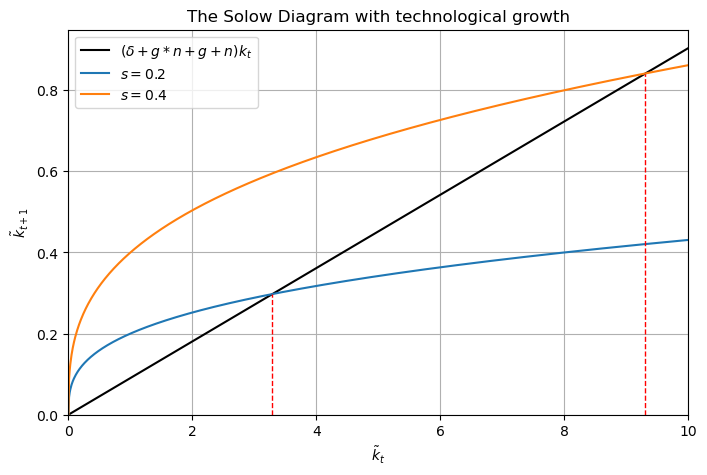

In [59]:
s = 0.2
delta = 0.05
n = 0.02
g = 0.02
alpha = 1/3

def solow_diagram_s(kmax_s: int, kline_s: float, s_values: list):
        # Definition of the values of k and the diagonal line
        k_values_s = np.linspace(0, kmax_s, 1000)
        diagonal_s = (n + g + delta + n*g) * k_values_s

        # The figure size and the graph
        plt.figure(figsize=(8, 5))
        plt.plot(k_values_s, diagonal_s, label=r'$(\delta+g*n+g+n)k_t$', color='black')

        # Plotting for each value of s
        for s in s_values:
            k_growth_s = s * k_values_s**alpha
            plt.plot(k_values_s, k_growth_s, label=f'$s={s}$')

        # Finding intersection points
        intersection_points = []
        for s in s_values:
            k_growth_s = s * k_values_s**alpha
            intersection_point = np.argwhere(np.diff(np.sign(k_growth_s - diagonal_s))).flatten()
            intersection_points.append((k_values_s[intersection_point], k_growth_s[intersection_point]))
        
        # Plotting dotted lines where the diagonal line and the curves intersect each other
        for point in intersection_points:
            x = point[0]
            y = point[1]
            plt.vlines(x, 0, y, colors='r', linestyles='--', lw=1)  

        # Figure details
        plt.xlim(0, kmax_s)
        plt.ylim(0, None)
        plt.xlabel('$\~{k}_t$')
        plt.ylabel('$\~{k}_{t+1}$')
        plt.legend()
        plt.title('The Solow Diagram with technological growth')
        plt.grid(True)
        plt.show()

solow_diagram_s(kmax_s=10, kline_s=5, s_values=[0.2, 0.4])

In the figure above we have considered a situation where the saving rate, s, increases from 0.2 to 0.4. This makes a shift upwards in the curve. The mechanism behind this is that a higher saving rate means that a larger proportion of the income will be saved. This means that savings will exceed population growth, and thus capital intensity and GDP per capita will increase until the new steady state is reached.

## 4 <a id='toc4_'></a>[Shock to Technological Growth](#toc0_)

We will now investigate what happens when there is a positive permanent shock to technological growth in the Solow Model with technological growth. We expect that a positive permanent shock to technological growth will make the diagonal line steeper. 

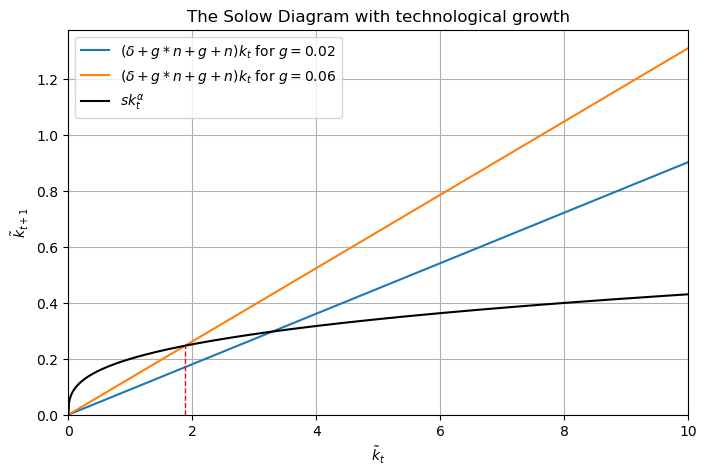

In [62]:
s = 0.2
delta = 0.05
n = 0.02
alpha = 1/3

def solow_diagram_g(kmax_g: int, g_values: list):
    # Definition of the values of k 
    k_values_g = np.linspace(0, kmax_g, 1000)
    k_growth_g = s * k_values_g**alpha

     # The figure size
    plt.figure(figsize=(8, 5))


     # Plotting for each value of g
    for g in g_values:
        diagonal_g = (n + g + delta + n*g) * k_values_g
        plt.plot(k_values_g, diagonal_g, label=f'$(\delta+g*n+g+n)k_t$ for $g={g}$')


        # Finding intersection points
        intersection_points = []
        intersection_indices = np.argwhere(np.diff(np.sign(k_growth_g - diagonal_g))).flatten()
        if intersection_indices.size > 0:
            for idx in intersection_indices:
                k_intersect = k_values_g[idx]
                k_growth_intersect = k_growth_g[idx]
                intersection_points.append((k_intersect, k_growth_intersect))

    plt.plot(k_values_g, k_growth_g, label=r'$s k_t^\alpha$', color='black')

    # Plotting dotted lines where the diagonal line and the curves intersect each other
    for point in intersection_points:
        x, y = point
        plt.vlines(x, 0, y, colors='r', linestyles='--', lw=1)

    # Figure details
    plt.xlim(0, kmax_g)
    plt.ylim(0, None)
    plt.xlabel('$\~{k}_t$')
    plt.ylabel('$\~{k}_{t+1}$')
    plt.legend()
    plt.title('The Solow Diagram with technological growth')
    plt.grid(True)
    plt.show()

solow_diagram_g(kmax_g=10, g_values=[0.02, 0.06])


In the figure above, it can be seen than an increase in technological growth will make the diagonal line steeper. When 
g increases, it means that technology is growing faster over time. The long-term effect of a higher technological growth rate is an increase in output per worker because the productivity is improved. is in As technology improves more rapidly, workers can produce more output with the same amount of capital and labor.

## 5 <a id='toc5_'></a>[Conclusion](#toc0_)

In this project we have analyzed the Solow Model with an extension with techonological growth. We did this extension due to the problem with the missing growth in the long run in The Basic Solow model which is unrealistic. Permanent shocks can change the steady state permanently. In the analysis it could be seen that a shock to the saving rate will make the savings outpace population growth which leads to an increase in capital intensity and GDP per capita until the economy reaches a new steady state. In the analysis we also investigated a permanent shock to technological growth. Here we found that a positiv permanent shock to technological growth will improve the productivity which will increase output per worker. 